**Training Deep Neural Networks**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

Unfortunately, ***gradients often get smaller and smaller*** as the algorithm progresses
down to the lower layers. As a result, the Gradient Descent update leaves the lower
layers’ connection weights virtually unchanged, and training never converges to a
good solution. We call this the ***vanishing gradients problem***. In some cases, the opposite
can happen: ***the gradients can grow bigger and bigger*** until layers get insanely
large weight updates and the algorithm diverges. This is the ***exploding gradients problem,***
which surfaces in recurrent neural networks (see Chapter 15). More generally,
deep neural networks suffer from unstable gradients; different layers may learn at
widely different speeds.

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def der_logit(z):
    return (1 -logit(z))*(logit(z))

Saving figure sigmoid_saturation_plot


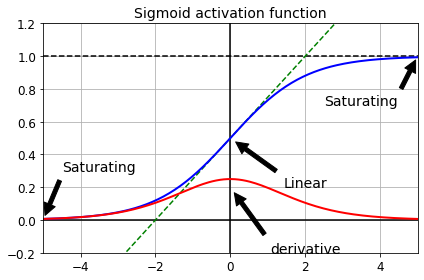

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
plt.plot(z, der_logit(z), "r-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.annotate('derivative', xytext=(2, -0.2), xy=(0, 0.2), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

1. Looking at the logistic activation function (see Figure above), you can see that when ***inputs become large (negative or positive),*** the function saturates at 0 or 1, with a ***derivative extremely close to 0***. 

2. Thus, when ***backpropagation*** kicks in it has virtually
no gradient to propagate back through the network; and what ***little gradient exists***
keeps getting diluted as backpropagation progresses down through the top layers, so
there is ***really nothing left for the lower layers.***

Q.what is gradient(derivative) for logistic activation function at saturation(at 0.0 and 1.0)from the above plot? what is their effect on backpropagation?

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


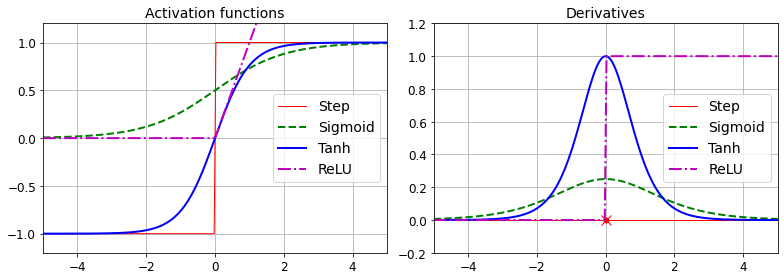

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

$Step(z) =0 \ $ if z < 0 

$Step(z) =1 \$ if  z ≥ 0


$Sigmoid(z) =\frac{1}{1+e^{-z}} \ $ 


$Tanh(z) =\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}} \ $


$ReLU(z) =max(0,z)\ $ 


Q WHAT are gradients(derivatives) at saturation for different functions in plots above? what is their effect on backpropagation?

Q ReLU does not saturate for positive values True or False?

Q ReLU does not saturate for negative values True or False?


1. ReLU activation function ***does not saturate***
for positive values (and because it is fast to compute).

2. ***Gradient*** of the ReLU function is ***zero when its input is negative***

3.  Problem is ***dying ReLUs:*** during training, some neurons effectively “die,” meaning inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative


## Weights Initialization

link for understanding Weights initialisation

https://medium.com/guidona-softpedia/weight-initialization-methods-in-neural-networks-a3e7a793cee5

https://wandb.ai/sayakpaul/weight-initialization-tb/reports/Effects-of-Weight-Initialization-on-Neural-Networks--Vmlldzo2ODY0NA

## Xavier and He Initialization

##Problem
In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable
gradients problem. They point out that we need ***the signal to flow properly in both
directions:*** in the forward direction when making predictions, and in the reverse
direction when backpropagating gradients. ***We don’t want the signal to die out, nor
do we want it to explode and saturate.***
##Solution
 For the signal to flow properly, the authors
argue that we need the ***variance of the outputs of each layer to be equal to the variance
of its inputs,and we need the gradients to have equal variance before and after
flowing through a layer in the reverse direction*** (please check out the paper if you are
interested in the mathematical details). 

1. It is actually not possible to guarantee both
unless the layer has an ***equal number of inputs and neurons*** (these numbers are called
the fan-in and fan-out of the layer),

2. but Glorot and Bengio proposed a good compromise
that has proven to work very well in practice: the connection weights of each
layer must be initialized randomly as described in Equation below, where $fan_{avg }= \frac{(fan_{in}
+ fan_{out})}{2}$. This initialization strategy is called Xavier initialization or Glorot initialization,
after the paper’s first author.



Equations for ***Glorot initialization*** (when using the logistic activation function)

Normal distribution with mean 0 and variance$ σ^2 = \frac{1}
{fan_{avg}}$

Or a uniform distribution between −r and + r, with r = $ \sqrt \frac{3}
{fan_{avg}}$



If you replace $\ fan_{avg}$ with $\ fan_{in}$ in Equations above, you get an initialization strategy that
Yann LeCun proposed in the 1990s. He called it ***LeCun initialization. Genevieve Orr***
and Klaus-Robert Müller even recommended it in their 1998 book Neural Networks:
Tricks of the Trade (Springer). ***LeCun initialization is equivalent to Glorot initialization***
when $ \ fan_{in} = fan_{out}$

###Significance

 It took over a decade for researchers to realize how important
this trick is. Using Glorot initialization can ***speed up training considerably***, and it is
one of the tricks that led to the success of Deep Learning.



Some papers have provided similar ***strategies for different activation functions.***

These strategies differ only by the scale of the variance and whether they use $ \ fan_{avg} \ $or $ \ fan_{in} \ $
 as shown in Table below (for the uniform distribution, just compute r = $\sqrt {3σ^2}$).


| Initialization| Activation    | normal $σ^2$     |$Uniform \sqrt{3σ^2}$  |
| :---          |      :----:   |             ---: |               ---: |
| Glorot        | None,tanh,logistic,softmax | $\frac{1}{fan_{avg}}$ |$\sqrt{\frac{3}{fan_{avg}}}$|   
| He            | RELU         | $\frac{2}{fan_{in}}$         | $\sqrt{\frac{6}{fan_{in}}}$                   |
| Lecun         | SELU         | $\frac{1}{fan_{in}}$         |  $\sqrt{\frac{3}{fan_{in}}}$                  |


1. The initialization strategy for the ReLU activation function (and its variants, including
the ELU activation described shortly) is sometimes called He initialization, after
the paper’s first author. 

2. The SELU activation function will be explained later in this
chapter. It should be used with LeCun initialization (preferably with a normal distribution,
as we will see).

## Different initialisers in keras

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

## Usage of initialiser in keras

By ***default, Keras uses Glorot initialization with a uniform distribution. ***When creating
a layer, you can change this to He initialization by setting kernel_initial
izer="he_uniform" or kernel_initializer="he_normal" like this:

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

##Change initialiser parameters

If you want He initialization with a ***uniform distribution*** but based on $fan_{avg}$ rather
than $fan_{in}$, you can use the VarianceScaling initializer like this:


In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


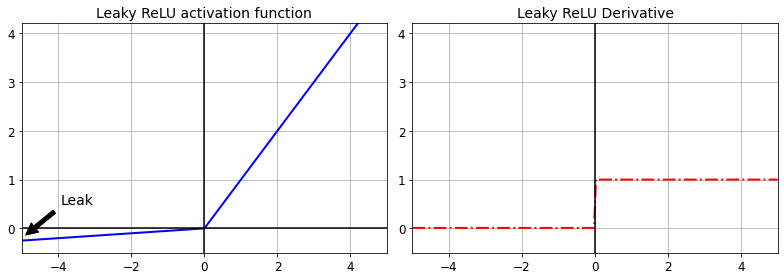

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))
plt.subplot(121)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.subplot(122)


plt.plot(z, derivative(leaky_relu, z), "r-.", linewidth=2, label="leaky_ReLU")
#plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)

plt.title("Leaky ReLU Derivative", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])


save_fig("leaky_relu_plot")
plt.show()

1. ReLU activation function ***does not saturate***
for positive values (and because it is fast to compute).

2. ***Gradient*** of the ReLU function is ***zero when its input is negative***

3.  Problem is ***dying ReLUs:*** during training, some neurons effectively “die,” meaning inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative

4. ***To solve this problem,*** you may want to use a variant of the ReLU function, such as the ***leaky ReLU.***

 1. This function is defined as ***LeakyReLUα(z) = max(αz, z)*** (see
Figure above). The ***hyperparameter α defines how much the function “leaks”:*** it is the ***slope of the function for z < 0*** and is typically set to 0.01. This small slope ensures that ***leaky ReLUs never die;*** they can go into a long coma, but they have a chance to eventually wake up.

 2. A 2015 paper5 compared several variants of the ReLU activation function,
and one of its conclusions was that the ***leaky variants always outperformed the
strict ReLU activation function.*** In fact, setting α = 0.2 (a huge leak) seemed to result in better performance than α = 0.01 (a small leak).

 3. The paper also evaluated the ***randomized leaky ReLU (RReLU), where α is picked randomly*** in a given range during training and is fixed to an average value during testing. ***RReLU also performed fairly well*** and seemed to act as a regularizer (reducing the risk of overfitting the training set). 

4. Finally, the paper evaluated the *** parametric leaky ReLU (PReLU), where α is authorized to be learned during training*** (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). ***PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.***

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 41us/sample - loss: 1.2810 - accuracy: 0.6205 - val_loss: 0.8869 - val_accuracy: 0.7160
Epoch 2/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.7952 - accuracy: 0.7369 - val_loss: 0.7132 - val_accuracy: 0.7626
Epoch 3/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6817 - accuracy: 0.7726 - val_loss: 0.6385 - val_accuracy: 0.7894
Epoch 4/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6219 - accuracy: 0.7942 - val_loss: 0.5931 - val_accuracy: 0.8016
Epoch 5/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5830 - accuracy: 0.8074 - val_loss: 0.5607 - val_accuracy: 0.8170
Epoch 6/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5552 - accuracy: 0.8172 - val_loss: 0.5355 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [==============================] -

Now let's try PReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 47us/sample - loss: 1.3452 - accuracy: 0.6203 - val_loss: 0.9241 - val_accuracy: 0.7170
Epoch 2/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.8196 - accuracy: 0.7364 - val_loss: 0.7314 - val_accuracy: 0.7600
Epoch 3/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.6970 - accuracy: 0.7701 - val_loss: 0.6517 - val_accuracy: 0.7880
Epoch 4/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.6333 - accuracy: 0.7914 - val_loss: 0.6032 - val_accuracy: 0.8050
Epoch 5/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.5916 - accuracy: 0.8049 - val_loss: 0.5689 - val_accuracy: 0.8162
Epoch 6/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.5619 - accuracy: 0.8143 - val_loss: 0.5416 - val_accuracy: 0.8222
Epoch 7/10
55000/55000 [==============================] -

### ELU

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


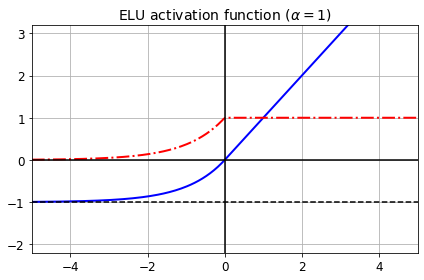

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot(z, derivative(elu, z), "r-.", linewidth=2, label="eLU")

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Last but not least, a 2015 paper by Djork-Arné Clevert et al.6 proposed a new activation function called the ***exponential linear unit (ELU)*** that outperformed all the ReLU variants in the authors’ experiments: ***training time was reduced, and the neural network performed better on the test set.*** 

Figure above graphs the function, and Equation below shows its definition.

$ELU_α(z) =α (exp (z − 1)) \ $ if z < 0 

$ELU_α(z) =z \$ if  z ≥ 0

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. 

During training, a neural network composed exclusively of a stack of dense layers using the ***SELU activation function and LeCun initialization.***

This  will self-normalize: ***the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem.***

 As a result, this activation function ***outperforms the other activation functions*** very significantly for such neural nets, so you should really try it out.

###Problems 
  Unfortunately, the ***self-normalizing property of the SELU activation function is easily broken:*** you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize).
  
However, in practice it ***works quite well with sequential CNNs.***
   
 If you break self-normalization, SELU will not necessarily outperform other activation functions.

###Procedure For SELU
1. The input features must be standardized (mean 0 and standard deviation 1).
2. Every hidden layer’s weights must be initialized with LeCun normal initialization.
In Keras, this means setting kernel_initializer="lecun_normal".
3. The network’s architecture must be sequential.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


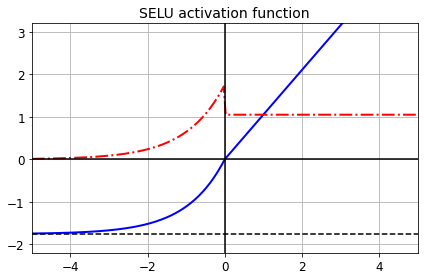

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot(z, derivative(selu, z), "r-.", linewidth=2, label="SeLU")

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

$SELU(z)=λz \ $ if z>0

$SELU(z)=λ(αe^z-α) \ $ if z<0

1. By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too).
2. Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 13s 238us/sample - loss: 1.1277 - accuracy: 0.5573 - val_loss: 0.8152 - val_accuracy: 0.6700
Epoch 2/5
55000/55000 [==============================] - 11s 198us/sample - loss: 0.6935 - accuracy: 0.7383 - val_loss: 0.5806 - val_accuracy: 0.7928
Epoch 3/5
55000/55000 [==============================] - 11s 196us/sample - loss: 0.5871 - accuracy: 0.7865 - val_loss: 0.6876 - val_accuracy: 0.7462
Epoch 4/5
55000/55000 [==============================] - 11s 199us/sample - loss: 0.5281 - accuracy: 0.8134 - val_loss: 0.5236 - val_accuracy: 0.8230
Epoch 5/5
55000/55000 [==============================] - 11s 201us/sample - loss: 0.4824 - accuracy: 0.8327 - val_loss: 0.5201 - val_accuracy: 0.8312


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 12s 213us/sample - loss: 1.7518 - accuracy: 0.2797 - val_loss: 1.2328 - val_accuracy: 0.4720
Epoch 2/5
55000/55000 [==============================] - 10s 177us/sample - loss: 1.1922 - accuracy: 0.4982 - val_loss: 1.0247 - val_accuracy: 0.5354
Epoch 3/5
55000/55000 [==============================] - 10s 178us/sample - loss: 0.9390 - accuracy: 0.6180 - val_loss: 1.0809 - val_accuracy: 0.5118
Epoch 4/5
55000/55000 [==============================] - 10s 178us/sample - loss: 0.7787 - accuracy: 0.6937 - val_loss: 0.7067 - val_accuracy: 0.7344
Epoch 5/5
55000/55000 [==============================] - 10s 180us/sample - loss: 0.7465 - accuracy: 0.7122 - val_loss: 0.9720 - val_accuracy: 0.5702


Not great at all, we suffered from the vanishing/exploding gradients problem.

 ***which activation function should you use for the hidden layers
of your deep neural networks? ***

***In general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh> Sigmoid.***


 1. If the ***network’s architecture prevents it from selfnormalizing,***
then ELU may perform better than SELU (since SELU
is not smooth at z = 0).

 2. If you care a lot about ***runtime latency***, then
you may prefer leaky ReLU. If you don’t want to tweak yet another
hyperparameter, you may use the default α values used by Keras
(e.g., 0.3 for leaky ReLU).

 3. If you have ***spare time and computing power,*** you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set.

 4. That said, because ***ReLU is the most used activation function (by far),*** many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

# Batch Normalization

Link for visual understanding of batch Normalization

https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.8760 - accuracy: 0.7122 - val_loss: 0.5509 - val_accuracy: 0.8224
Epoch 2/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.5737 - accuracy: 0.8039 - val_loss: 0.4723 - val_accuracy: 0.8460
Epoch 3/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.5143 - accuracy: 0.8231 - val_loss: 0.4376 - val_accuracy: 0.8570
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4826 - accuracy: 0.8333 - val_loss: 0.4135 - val_accuracy: 0.8638
Epoch 5/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4571 - accuracy: 0.8415 - val_loss: 0.3990 - val_accuracy: 0.8654
Epoch 6/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.4432 - accuracy: 0.8456 - val_loss: 0.3870 - val_accuracy: 0.8710
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.8656 - accuracy: 0.7094 - val_loss: 0.5650 - val_accuracy: 0.8098
Epoch 2/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5766 - accuracy: 0.8018 - val_loss: 0.4834 - val_accuracy: 0.8358
Epoch 3/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5184 - accuracy: 0.8216 - val_loss: 0.4461 - val_accuracy: 0.8470
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4852 - accuracy: 0.8314 - val_loss: 0.4226 - val_accuracy: 0.8558
Epoch 5/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4579 - accuracy: 0.8399 - val_loss: 0.4086 - val_accuracy: 0.8604
Epoch 6/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4406 - accuracy: 0.8457 - val_loss: 0.3974 - val_accuracy: 0.8640
Epoch 7/10
55000/55000 [==============================] -

## Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to ***clip the
gradients during backpropagation*** so that they never exceed some threshold. This is
called Gradient Clipping. This technique is most often used in recurrent neural networks,
as ***Batch Normalization is tricky to use in RNNs***, as we will see in Chapter 15.
For other types of networks, BN is usually sufficient.



This optimizer will ***clip every component of the gradient vector to a value*** between ***–1.0 and 1.0.*** This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.

 The threshold is a hyperparameter you can tune. Note that it may ***change the orientation of the gradient vector.*** For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. 

If you want to ensure that Gradient Clipping does not change the direction
of the gradient vector, you should ***clip by norm*** by setting clipnorm instead of clipvalue. This will clip the whole gradient if its *** ℓ2 norm is greater than the threshold you picked.*** For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.

 If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), ***you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.*** 

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)